In [1]:
import os
import sys
from scipy import stats
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, ShuffleSplit
from tqdm import tqdm
import warnings
import matplotlib as mpl
import plot_utils

from string import ascii_lowercase as abc
abc = [*abc] + [f'{l}2' for l in abc]

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Colors

In [5]:
ot1_color = 'tab:green'
palette_tcrs = {'OT1': ot1_color, 
                'OTI': ot1_color, 
                'Educated': 'tab:orange',
                'Naive': 'tab:blue', 
                'Human': 'Firebrick'
               }

palette_educated = sb.color_palette('Oranges', 16)[:8]
palette_naive_test = 'Blues'
palette_naive_ot1 = 'Greens'
palette_human = sb.color_palette('Reds', 16)[8-1:]

color_cdr3 = 'violet'

cmap_distances = 'viridis_r'

## Load data

In [6]:
def load_data_permutation_importance(epitope='VPSVWRSSL'):
    fname = f'../activation-prediction/results/{epitope}_tcr_stratified_permutation_importance_regression.csv.gz'
    pdf = pd.read_csv(fname)

    mdf =  pdf.groupby(['tcr', 'group', 'shuffle']).apply(lambda g: pd.Series({
        'mae': g['abserr'].mean(),
        'r2': metrics.r2_score(g['activation'], g['pred']),
        'pearson': g['activation'].corr(g['pred'], method='pearson'),
        'spearman': g['activation'].corr(g['pred'], method='spearman'),
    })).reset_index().drop(columns='shuffle')
    

    ddf = mdf.melt(['tcr', 'group']).merge(
        mdf[
            mdf['group'] == 'all'
        ].drop(columns='group').melt('tcr', value_name='base').drop_duplicates(),
        on=['tcr', 'variable']
    )
    ddf['diff'] = ddf['value'] - ddf['base']
    ddf['rel'] = ddf['value'] / ddf['base'] - 1  # positive = increase
    ddf['item'] = ddf['group'].str.split('_').str[0]
    ddf['is_educated'] = np.where(
        ddf['tcr'].str.startswith('ED') | ddf['tcr'].str.startswith('R'),
        'Educated', 'Naive'
    )
    permutation_data = ddf[(
        ddf['is_educated'] == "Educated"
    ) & (
        ddf['variable'] == 'spearman'
    ) & (
        ddf['group'].str.startswith('pos_')
          | ddf['group'].isin(['cdr3', 'all'])
    )].rename(columns={
        'value': 'Spearman', 'group': 'Permutation'
    })
    permutation_data = permutation_data.replace({
        'pos_0': 'P1', 'pos_1': 'P2', 'pos_2': 'P3', 'pos_3': 'P4',
        'pos_4': 'P5', 'pos_5': 'P6', 'pos_6': 'P7', 'pos_7': 'P8', 'pos_8': 'P9',
        'cdr3': 'CDR3', 'all': '-'
    })
    return permutation_data
df_importance_mice = load_data_permutation_importance('SIINFEKL')
df_importance_human = load_data_permutation_importance()

In [7]:
def load_available_visualisations(repertoire='human'):
    path_in = f'figures/3dModel/{repertoire}'
    files = os.listdir(path_in)
    files = [el.split('_')[0] for el in files]
    if 'R27' in files:
        files.remove('R27')
    return files

vis_names_human = load_available_visualisations('human')
vis_names_mice = load_available_visualisations('mice')

In [8]:
def load_3D_distances(epitope='SIINFEKL'):
    path_in = '../results/model3d/'
    path_in += 'mice' if epitope == 'SIINFEKL' else 'tumor'
    
    tcrs = vis_names_mice if epitope == 'SIINFEKL' else vis_names_human
    
    distances_alpha = {tcr: pd.read_csv(f'{path_in}/{tcr}_{epitope}_alpha.csv', index_col=0) for tcr in tcrs}
    distances_beta = {tcr: pd.read_csv(f'{path_in}/{tcr}_{epitope}_beta.csv', index_col=0) for tcr in tcrs}
    
    min_epitope_distances = {}
    for tcr in distances_alpha.keys():
        min_distances = np.stack([distances_alpha[tcr].values.min(axis=1), distances_beta[tcr].values.min(axis=1)])
        min_distances = np.min(min_distances, axis=0)
        min_epitope_distances[tcr] = min_distances
    return min_epitope_distances

dists_human = load_3D_distances('VPSVWRSSL')
dists_mice = load_3D_distances('SIINFEKL')

## Plotting function

In [9]:
def plot_permutation_importance_base(data, ax, palette):
    vmin = data['Spearman'].min() - 0.1
    data = data[data['item']!='pos']
    g = sb.boxplot(
        data=data,
        x='Permutation',
        y='Spearman',
        palette=palette,
        zorder=2,
        showmeans=True,
        notch=False,
        meanprops={'mfc': 'k', 'mec': 'k'},
        ax=ax,
    )
    g.set(ylim=(vmin, 1), ylabel=None, xlabel=None)

    ax.grid(False)
    sb.despine(ax=ax)
    ax.set_ylabel('Spearman')
    ax.tick_params(axis='x', which='major', pad=-2)

In [10]:
def plot_permutation_importance_position(data, ax, palette=palette_educated):
    vmin = data['Spearman'].min() - 0.1
    data = data[data['item']=='pos']
    g = sb.boxplot(
        data=data,
        x='Permutation',
        y='Spearman',
        palette=palette,
        zorder=2,
        showmeans=True,
        notch=False,
        meanprops={'mfc': 'k', 'mec': 'k'},
        ax=ax,
    )
    g.set(ylim=(vmin, 1), ylabel=None, xlabel=None)

    ax.grid(False)
    sb.despine(ax=ax, left=True)
    ax.set_yticklabels([])
    ax.tick_params(axis='x', which='major', pad=-2)

In [11]:
def plot_3d_structures(ax, tcr):
    def get_crop_border(axis, direction):
        axis_sum = img[:, :, 3].sum(axis=axis)
        indices = np.where(axis_sum>0)[0]
        return direction(indices)
    rep = 'human' if tcr.startswith('R') else 'mice'
    path_tcr = f'figures/3dModel/{rep}/{tcr}_colored.png'
    img = mpl.image.imread(path_tcr)
    
    x0 = get_crop_border(0, min)
    x1 = get_crop_border(0, max)
    y0 = get_crop_border(1, min)
    y1 = get_crop_border(1, max)
    img = img[y0:y1, x0:x1]
    
    ax.imshow(img)
    ax.grid(False)
    sb.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])

In [12]:
def plot_3d_distances(ax, tcr, vmin=None, vmax=None, do_labels=True):
    len_epitope = 9 if tcr.startswith('R') else 8  
    dists = dists_human if tcr.startswith('R') else dists_mice
    
    if not vmin is None:
        vmin = min([d.min() for d in dists.values()])
        vmax = max([d.max() for d in dists.values()])
    if not 'avg' in tcr:
        dist = dists[tcr].reshape((1, -1))
    else:
        dist = np.vstack(list(dists.values())).mean(axis=0).reshape((1, -1))
    x_labels = [f'P{i + 1}' for i in range(len_epitope)] if do_labels else []
    plot = sb.heatmap(dist, square=not 'avg' in tcr,
                       vmin=vmin, vmax=vmax, cmap=cmap_distances,
                       xticklabels=x_labels, cbar=False, ax=ax)
    tcr = tcr if tcr != 'OT1' else 'OTI'
    tcr = tcr if not 'avg' in tcr else 'Distance averaged over TCR'
    plot.set_xlabel(tcr)
    plot.set_yticks([])
    plot.set_xticklabels(x_labels, size='x-small', rotation=0)
    ax.tick_params(bottom=True, width=0.5, length=2, pad=1)

In [13]:
def plot_colorbar(ax, epitope):
    
    dists = dists_human if epitope != 'SIINFEKL' else dists_mice
    vmin = min([d.min() for d in dists.values()])
    vmax = max([d.max() for d in dists.values()])
    
    if epitope == 'both':
        vmin = min(vmin, min([d.min() for d in dists_mice.values()])) 
        vmax = max(vmax, max([d.max() for d in dists_mice.values()]))
    
    norm = mpl.colors.Normalize(vmin, vmax)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_distances), pad=0.25, ax=ax)
    #cb.ax.yaxis.set_ticks_position('left')
    cb.set_label('Distance in Å', rotation=-90, labelpad=6)
    #cb.ax.yaxis.set_label_position('left')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    sb.despine(ax=ax, bottom=True, left=True)
    cb.ax.tick_params(width=0.5, length=3, pad=2)
    
    return vmin, vmax

In [14]:
def plot_human(ax, scale=1):
    img = plt.imread('../figures/human.png')
    color_human = mpl.colors.to_rgba(palette_tcrs['Human'])
    for i, c in enumerate(color_human):
        img[img[:,:,i]!=1, i] = c
    width_height = img.shape[1] / img.shape[0]
    
    left = -1.3*scale
    top = -0.4 * left * width_height 
    ax.imshow(img, extent=[left/2, -1*left/2, 0, top], #[0, 1, 0, 1], 
              alpha=0.5, aspect='auto')

## Figure 5

<ipython-input-15-aa1d7a9580f3>:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


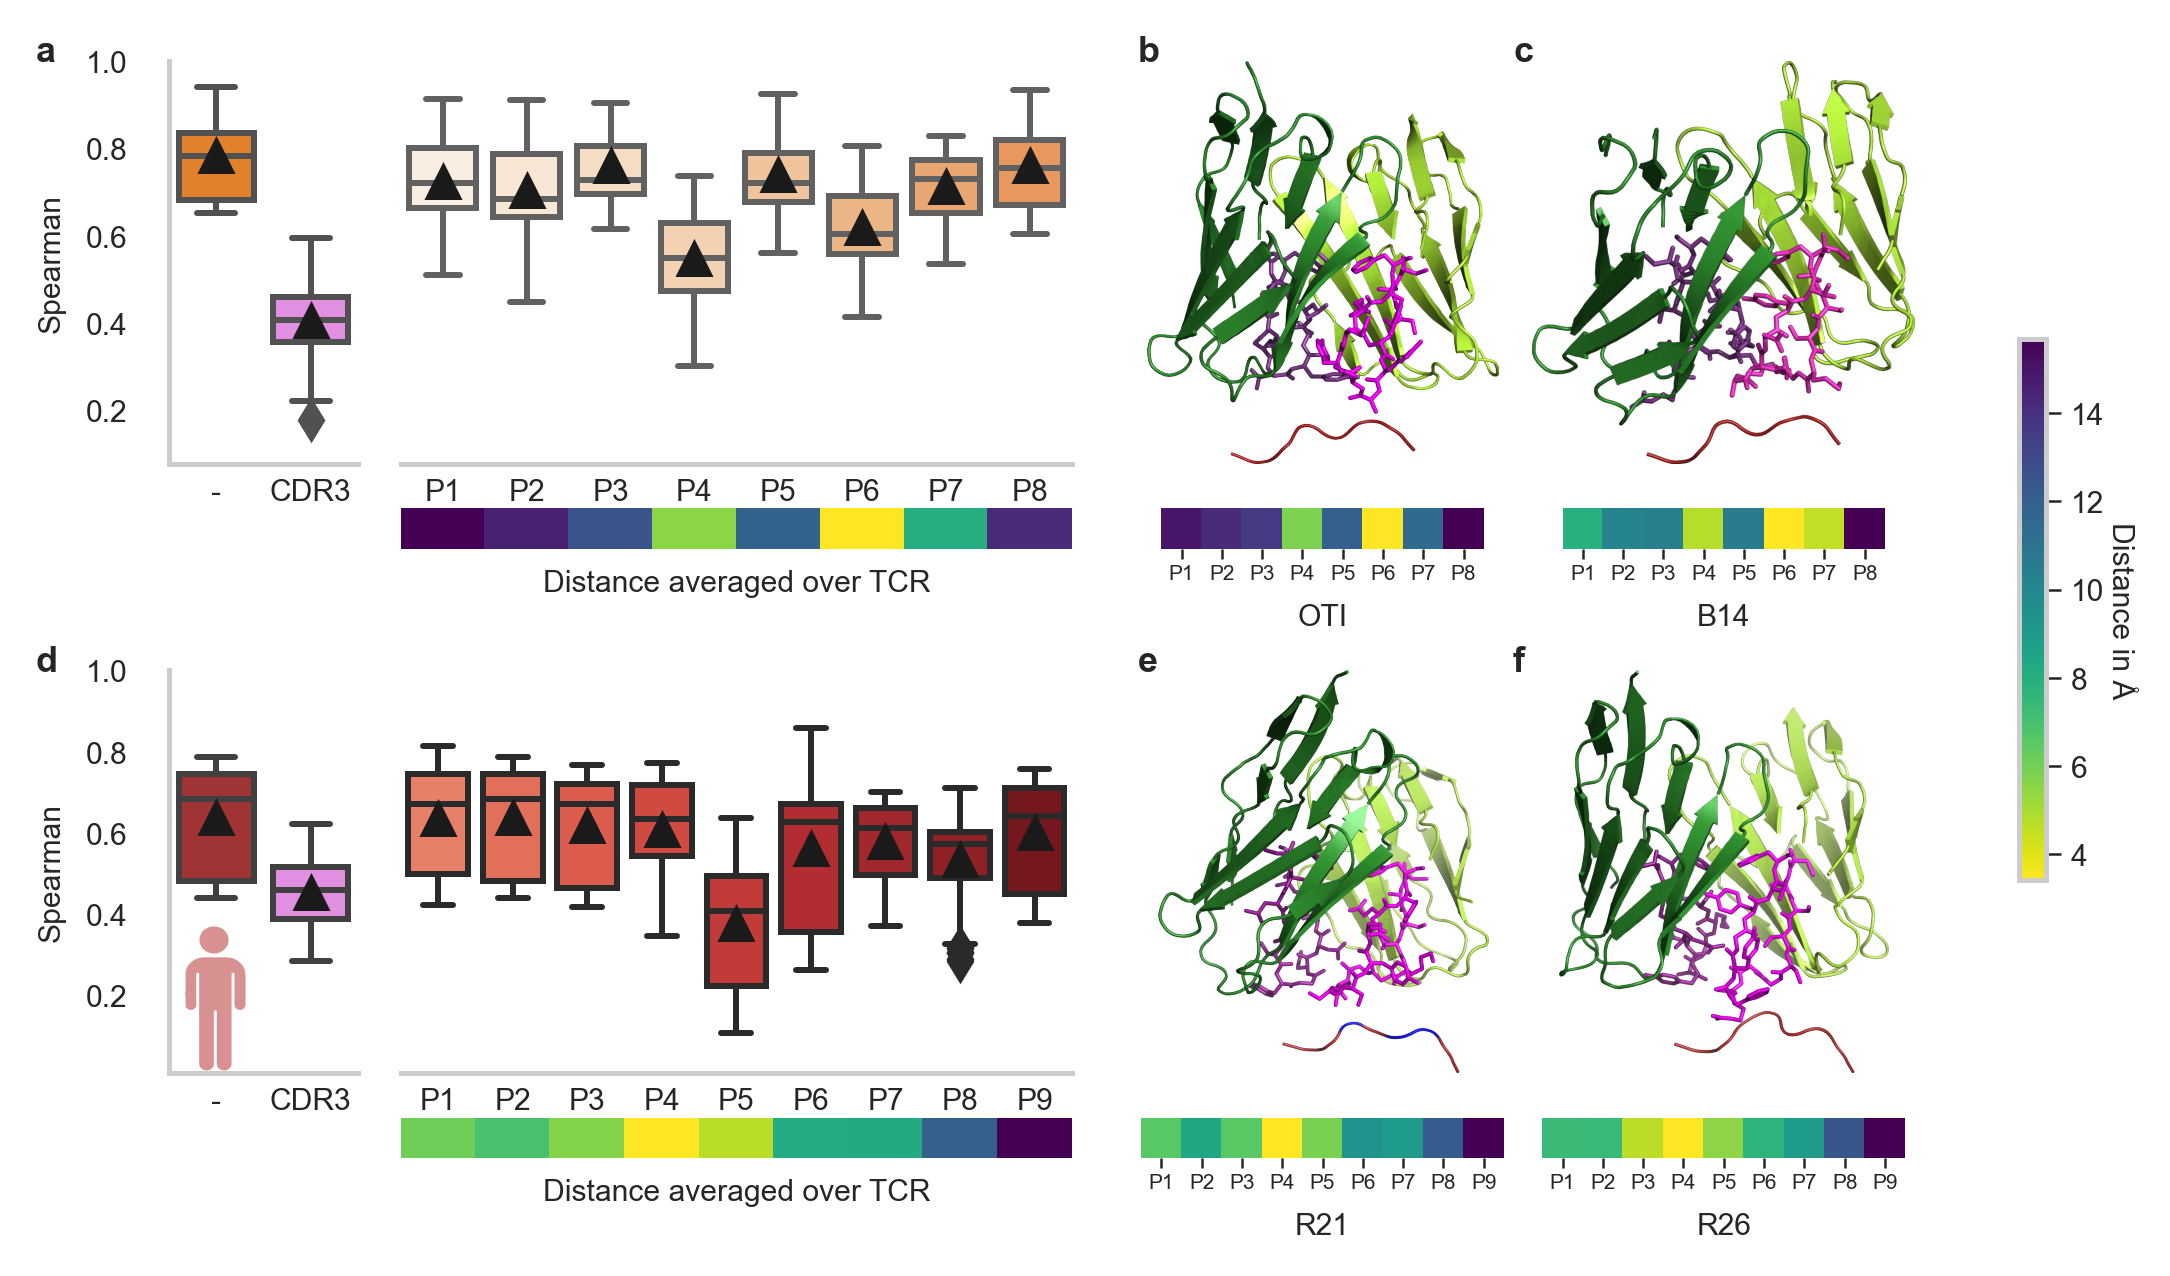

In [15]:
# base featureImportance  model1 model2 c
# base featureImportance  model1 model2 o
#      avg distances      dist 1 dist 2 l
#                                       
# base featureImportance  model1 model2 b       => same for human
# base featureImportance  model1 model2 a
#      avg distances      dist 1 dist 2 r


fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.6), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs1-15'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[10, 1],
    wspace=-0.11,
    #hspace=2/3,
)

gridspecs['gs1-14'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs1-15'][0],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    hspace=0.25
)

axes['cbar'] = fig.add_subplot(gridspecs['gs1-15'][1])
vmin, vmax = plot_colorbar(axes['cbar'], epitope='both')

tcr_mice = ('OT1', 'B14')
tcr_human = ('R21', 'R26')

for i, (dataset, tcrs) in enumerate([('mice', tcr_mice), ('human', tcr_human)]):
    gridspecs['gs1-7'] = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gridspecs['gs1-14'][i],
        nrows=1,
        ncols=2,
        width_ratios=[1, 1],
        wspace=0.0
    )
    gridspecs['gs1-3'] = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gridspecs['gs1-7'][0],
        nrows=2,
        ncols=2,
        height_ratios=[10, 1],
        width_ratios=[2.25, 8],
        wspace=0.1
    )
    gridspecs['gs4-7'] = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gridspecs['gs1-7'][1],
        nrows=2,
        ncols=2,
        height_ratios=[10, 1],
        width_ratios=[1, 1],
        wspace=-0.2
        #hspace=-0.15
    )    
    axes['ax_1'] = fig.add_subplot(gridspecs['gs1-3'][0])
    axes['ax_2'] = fig.add_subplot(gridspecs['gs1-3'][1])
    axes['ax_3'] = fig.add_subplot(gridspecs['gs1-3'][3])
    
    palette = palette_human if dataset=='human' else palette_educated
    palette_base = [palette_tcrs['Human'], color_cdr3] if dataset=='human' else [palette_tcrs['Educated'], color_cdr3]
    average_class = 'avg' if dataset=='mice' else 'Ravg'
    df_importance = df_importance_human if dataset=='human' else df_importance_mice

    if dataset == 'human':
        plot_human(axes['ax_1'])
    
    plot_permutation_importance_base(df_importance, axes['ax_1'], palette_base)
    plot_permutation_importance_position(df_importance, axes['ax_2'], palette=palette)
    plot_3d_distances(axes['ax_3'], average_class, do_labels=False)
        
    axes['ax_4'] = fig.add_subplot(gridspecs['gs4-7'][0])
    axes['ax_5'] = fig.add_subplot(gridspecs['gs4-7'][1])
    axes['ax_6'] = fig.add_subplot(gridspecs['gs4-7'][2])
    axes['ax_7'] = fig.add_subplot(gridspecs['gs4-7'][3])
    
    plot_3d_structures(axes['ax_4'], tcrs[0])
    plot_3d_structures(axes['ax_5'], tcrs[1])
    plot_3d_distances(axes['ax_6'], tcrs[0])
    plot_3d_distances(axes['ax_7'], tcrs[1])
    
    fig.text(0.07, 0.88-i*0.42, abc[0+i*3], size='large', weight='bold')
    fig.text(0.525, 0.88-i*0.42, abc[1+i*3], size='large', weight='bold')
    fig.text(0.68, 0.88-i*0.42, abc[2+i*3], size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_fig5_importance.pdf', dpi=DPI, bbox_inches='tight')

## Figure S5

In [ ]:
n_cols = 6
n_rows = (len(vis_names_mice)-1)//6 + 1

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.25 * n_rows), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[10, 1],
    wspace=-0.12,
)

gs_vis = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[0],
    nrows=n_rows,
    ncols=n_cols,
    height_ratios=[1]*n_rows,
    width_ratios=[1] * n_cols,
    wspace=0.1,
    hspace=0.2
)

ax_cb = fig.add_subplot(gs[1])
plot_colorbar(ax_cb, 'SIINFEKL')

for i, tcr in enumerate(vis_names_mice):
    row = i//n_cols
    col = i%n_cols
    gs_tcr = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gs_vis[i],
        nrows=2,
        ncols=1,
        height_ratios=[1, 0.1],
        hspace=-0.
    )
    ax_struc = fig.add_subplot(gs_tcr[0])
    plot_3d_structures(ax_struc, tcr)
    
    ax_dists = fig.add_subplot(gs_tcr[1])
    plot_3d_distances(ax_dists, tcr)
    
    fig.text(0.125 + 0.127*col, 0.87-row*0.129, abc[i], size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_s5_3d_model_mice.pdf', dpi=DPI, bbox_inches='tight')

## Figure S6

In [ ]:
n_cols = 6
n_rows = (len(vis_names_human)-1)//6 + 1

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.25 * n_rows), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[10, 1],
    wspace=-0.12,
)

gs_vis = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[0],
    nrows=n_rows,
    ncols=n_cols,
    height_ratios=[1]*n_rows,
    width_ratios=[1] * n_cols,
    wspace=0.1,
    hspace=0.2
)

ax_cb = fig.add_subplot(gs[1])
plot_colorbar(ax_cb, 'VPR')

for i, tcr in enumerate(vis_names_human):
    row = i//n_cols
    col = i%n_cols
    gs_tcr = mpl.gridspec.GridSpecFromSubplotSpec(
        subplot_spec=gs_vis[i],
        nrows=2,
        ncols=1,
        height_ratios=[1, 0.1],
        hspace=-0.2
    )
    ax_struc = fig.add_subplot(gs_tcr[0])
    plot_3d_structures(ax_struc, tcr)
    
    ax_dists = fig.add_subplot(gs_tcr[1])
    plot_3d_distances(ax_dists, tcr)
    
    fig.text(0.125 + 0.127*col, 0.78-row*0.13, abc[i], size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_s6_3d_model_human.pdf', dpi=DPI, bbox_inches='tight')